<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/WS04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# !pip install folium

In [12]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# ---- Fetch Latest COVID-19 Data from GitHub ----
#base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
#latest_date = "02-13-2020.csv"  # Update with the latest date in MM-DD-YYYY format
#url = base_url + latest_date
#print(url)


In [14]:
# ---- Step 1: Load the Dataset ----
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/01-02-2023.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/01-02-2023.csv'  # Local path

Mounted at /content/drive


In [19]:
# Load dataset
df = pd.read_csv(file_path)

In [20]:
df.describe()

,FIPS,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
count,3268.000000,3925.000000,3925.000000,4.016000e+03,4016.000000,0.0,0.0,3922.000000,3974.000000
mean,32405.943390,35.736183,-71.109728,1.646409e+05,1667.277141,NaN,NaN,27693.653663,3.396156
std,18056.381177,13.441327,55.361480,1.046512e+06,8705.465768,NaN,NaN,10388.048975,93.482133
min,60.000000,-71.949900,-178.116500,0.000000e+00,0.000000,NaN,NaN,0.000000,0.000000
25%,19048.500000,33.191535,-96.595639,3.737500e+03,46.000000,NaN,NaN,23345.450938,0.892777
50%,30068.000000,37.895700,-86.717326,1.050600e+04,130.500000,NaN,NaN,28611.368832,1.287045
75%,47041.500000,42.176955,-77.357900,4.577550e+04,465.250000,NaN,NaN,33164.946216,1.739872
max,99999.000000,71.706900,178.065000,3.830609e+07,183348.000000,NaN,NaN,218343.195266,5651.724138


In [17]:
df.head(1)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-01-03 04:21:07,33.93911,67.709953,207627,7849,NaN,NaN,Afghanistan,533.356919,3.780337


In [18]:

# ---- Data Preprocessing ----
# Select relevant columns
print(df.columns)  # Verify column names
columns_to_use = ["Country_Region", "Province_State", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Active"]
df = df[columns_to_use]


Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')


<ipython-input-10-a9b7c8a841ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
<ipython-input-10-a9b7c8a841ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Lat', 'Long_'], inplace=True)


✅ World Map with Clusters Saved as 'covid19_clusters_map.html'

📌 **Cluster Analysis Summary:**
            Confirmed         Deaths  Recovered  Active
Cluster                                                
0        7.083671e+04     762.828504        0.0     0.0
1        6.401312e+06  134833.375000        0.0     0.0
2        3.376334e+07   95469.000000        0.0     0.0
3        2.813963e+06   26374.573171        0.0     0.0
4        1.871753e+07  142420.000000        0.0     0.0


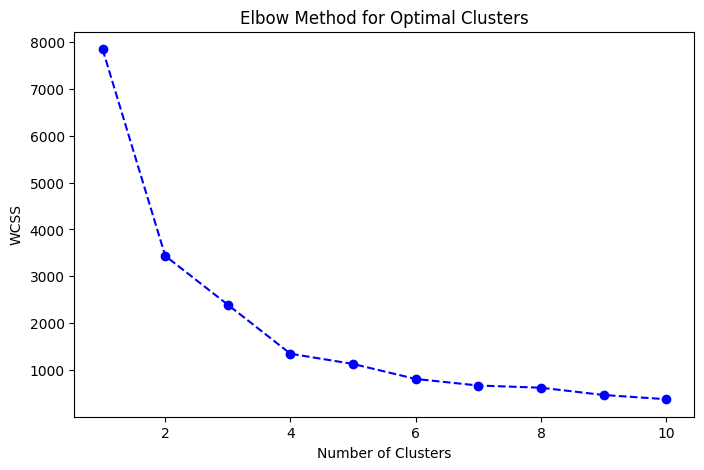

In [10]:

# Handle missing values
df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
df.dropna(subset=['Lat', 'Long_'], inplace=True)

# Normalize data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["Confirmed", "Deaths", "Recovered", "Active"]])

# ---- Apply K-Means Clustering ----
optimal_clusters = 5  # Change based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", max_iter=300, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# ---- Visualizing Clusters on a World Map ----
world_map = folium.Map(location=[20, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(world_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long_"]],
        popup=f"Country: {row['Country_Region']}<br>Confirmed: {row['Confirmed']}<br>Deaths: {row['Deaths']}<br>Recovered: {row['Recovered']}",
        icon=folium.Icon(color=["red", "blue", "green", "purple", "orange"][row["Cluster"]])
    ).add_to(marker_cluster)

# Save map to an HTML file
world_map.save("covid19_clusters_map.html")
print("✅ World Map with Clusters Saved as 'covid19_clusters_map.html'")
#print("✅ Map saved successfully!")

# Open the saved file in Jupyter Notebook
import webbrowser
webbrowser.open("covid19_clusters_map.html")


# ---- Clustering Insights ----
print("\n📌 **Cluster Analysis Summary:**")
print(df.groupby("Cluster")[["Confirmed", "Deaths", "Recovered", "Active"]].mean())

# ---- Elbow Method to Find Optimal Clusters ----
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()
